# Lab 9 - PCC177/BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## NLP

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Implementar técncias de PLN para resolver um problema de classificação de texto tóxico em portugues.

Data da entrega : Fim do período

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab.pdf"
- Envie o PDF via google [FORM](https://forms.gle/NeH2WCaqVG4n8iz88)

Este notebook é baseado em tensorflow e Keras.


# Importando bibliotecas e preparando o ambiente

Importando as bibliotecas

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

Montando o seu drive no colab.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Vamos carregar a base de dados "*Brazilian Portuguese Hatespeech dataset*". Para detalhes sobre o dataset e o problema em si, veja o [link do Kaggle](https://www.kaggle.com/datasets/hrmello/brazilian-portuguese-hatespeech-dataset/).

In [37]:
# Ler o arquivo CSV hate_speech_binary_classification_train.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_treino.csv' pelo caminho real do seu arquivo CSV
dados = pd.read_csv('/content/drive/MyDrive/datasets/hate_speech_binary_classification_train.csv')

# Ler o arquivo CSV hate_speech_binary_classification_test.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_teste.csv' pelo caminho real do seu arquivo CSV
dados_teste = pd.read_csv('/content/drive/MyDrive/datasets/hate_speech_binary_classification_test.csv')


Mostrar as primeiras linhas do DataFrame

In [38]:
print(dados.head())

                                                text  \
0  -Odeio feministas só falam merda\n-Vamos fazer...   
1  CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...   
2  Diferença entre 'manifestante' e 'terrorista'....   
3  É legal pra um presidente 'grampear' uma corri...   
4  não há como negar a biologia....por mais que a...   

                                             protext  class  
0  -Odeio feministas só falam merda -Vamos fazer ...      1  
1  CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...      0  
2  Diferença entre 'manifestante' e 'terrorista'....      1  
3  É legal pra um presidente 'grampear' uma corri...      0  
4  não há como negar a biologia....por mais que a...      0  


## Pré-processando os dados

Selecionando colunas específicas

In [39]:
dados_brutos = dados.iloc[:, 0]
X = dados.iloc[:, 1] # Coluna dos dados pré-processados
y = dados.iloc[:, 2] # Coluna dos rótulos

X_test = dados_teste.iloc[:, 1]  # Coluna dos dados pré-processados
y_test = dados_teste.iloc[:, 2]  # Coluna dos rótulos

Mostrar as primeiras linhas de cada coluna

In [40]:
print("Dados brutos:")
print(dados_brutos.head())
print("\nRótulos:")
print(y.head())
print("\nDados preprocessados:")
print(X.head())

Dados brutos:
0    -Odeio feministas só falam merda\n-Vamos fazer...
1    CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: text, dtype: object

Rótulos:
0    1
1    0
2    1
3    0
4    0
Name: class, dtype: int64

Dados preprocessados:
0    -Odeio feministas só falam merda -Vamos fazer ...
1    CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: protext, dtype: object


# Uma implementação ingênua para o problema

Abaixo uma implementação ingênua para o problema. Ela é ingênua por que desconsidera a ordem das palavras no texto.
Tente endendê-la e execute o treinamento.

### Pré-processamento

Primeira coisa é fixar as sementes para garantir a reproducibilidade dos resultados

In [41]:
np.random.seed(94)
tf.random.set_seed(94)

Codificação dos rótulos para 0 e 1

In [42]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.transform(y_test)

Tokenização e sequenciamento dos textos

In [43]:
max_length = 280  # Define o tamanho máximo das sequências
vocab_size = 100000  # Define o tamanho do vocabulário

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
# Tokenização e sequenciamento dos textos de treino
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Tokenização e sequenciamento dos textos de teste
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

Divisão dos dados em conjuntos de treino e validação

In [44]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

### Definição e treinamento do modelo

Definição do modelo

In [45]:
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [46]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 16)           1600000   
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 32)                143392    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1743425 (6.65 MB)
Trainable params: 1743425 (6.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo

In [48]:
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
72/72 - 11s - loss: 0.6940 - accuracy: 0.5074 - val_loss: 0.6934 - val_accuracy: 0.4965 - 11s/epoch - 155ms/step
Epoch 2/5
72/72 - 9s - loss: 0.6915 - accuracy: 0.5210 - val_loss: 0.6929 - val_accuracy: 0.4965 - 9s/epoch - 120ms/step
Epoch 3/5
72/72 - 4s - loss: 0.6714 - accuracy: 0.6224 - val_loss: 0.6749 - val_accuracy: 0.6101 - 4s/epoch - 61ms/step
Epoch 4/5
72/72 - 2s - loss: 0.4473 - accuracy: 0.8872 - val_loss: 0.6586 - val_accuracy: 0.6171 - 2s/epoch - 21ms/step
Epoch 5/5
72/72 - 2s - loss: 0.1396 - accuracy: 0.9755 - val_loss: 0.7236 - val_accuracy: 0.6311 - 2s/epoch - 22ms/step


Plotando as curvas de loss

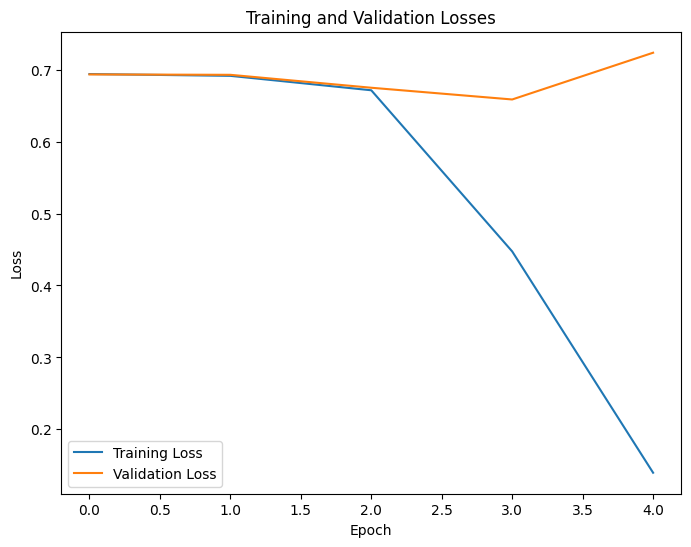

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [50]:
loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

23/23 - 0s - loss: 0.7166 - accuracy: 0.6411 - 61ms/epoch - 3ms/step
Perda nos dados de teste: 0.7166
Acurácia nos dados de teste: 0.6411


Previsões do modelo

In [55]:
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")

23/23 [==============================] - 0s 2ms/step


Gerando o relatório de classificação

In [56]:
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

Plotando os resultados

In [57]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.6095444685466378
	Recall: 0.7849162011173184
	F1-score: 0.6862026862026861
Class: 1
	Precision: 0.6980392156862745
	Recall: 0.4972067039106145
	F1-score: 0.5807504078303425
Class: macro avg
	Precision: 0.6537918421164561
	Recall: 0.6410614525139664
	F1-score: 0.6334765470165142
Class: weighted avg
	Precision: 0.6537918421164561
	Recall: 0.6410614525139665
	F1-score: 0.6334765470165143
Macro Avg: {'precision': 0.6537918421164561, 'recall': 0.6410614525139664, 'f1-score': 0.6334765470165142, 'support': 716}
Weighted Avg: {'precision': 0.6537918421164561, 'recall': 0.6410614525139665, 'f1-score': 0.6334765470165143, 'support': 716}


Plotando a matriz de confusão

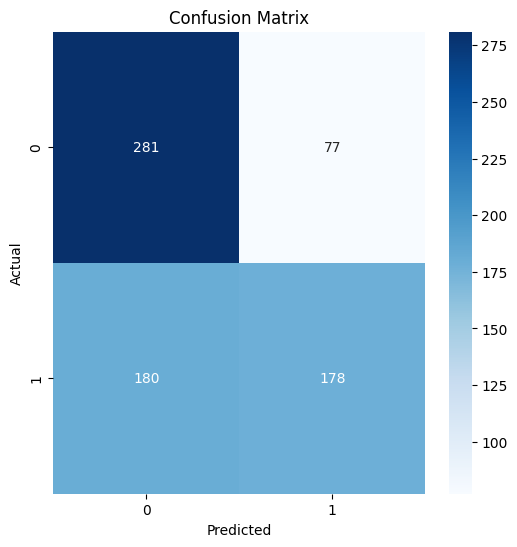

In [58]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### *ToDo*: O que você pode analisar dos resultados acima?

```
  Que o modelo funciona, porém na matrix de confusão há muitas unidades em Falso
  positivo que somadas com o Falso Negativo ainda são menores que os acertos
  do modelo, mas representa um número significativo que leva a pensar em melhorias.
```

# Faça o mesmo processamento utilizando GRU

Pelo menos duas camadas de GRU

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 gru (GRU)                   (None, 280, 32)           4800      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1611169 (6.15 MB)
Trainable params: 1611169 (6.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
72/72 - 14s - loss: 0.6938 - accuracy: 0.4913 - val_loss: 0.6932 - val_accuracy: 0.4965 - 14s/epoch - 193ms/step
Epoch 2/5
72/72 - 3s - lo

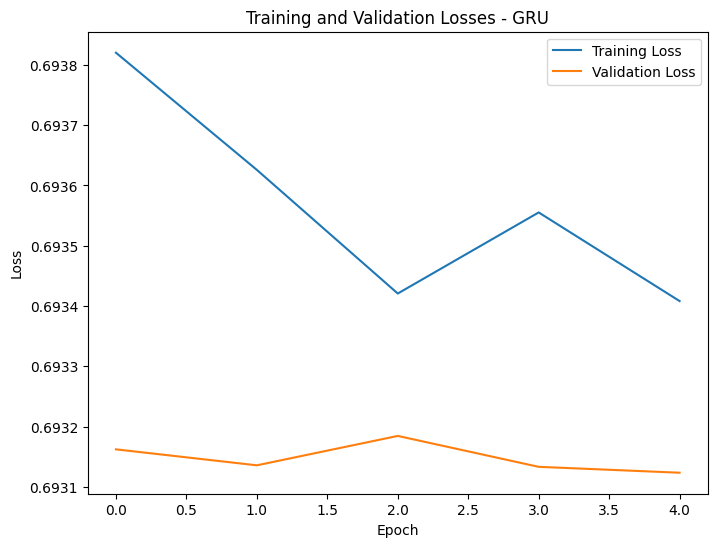

23/23 - 0s - loss: 0.6932 - accuracy: 0.5000 - 320ms/epoch - 14ms/step
Perda nos dados de teste (GRU): 0.6932
Acurácia nos dados de teste (GRU): 0.5000
23/23 [==============================] - 1s 12ms/step
Classificação Report (GRU):
Class: 0
	Precision: 0.5
	Recall: 1.0
	F1-score: 0.6666666666666666
Class: 1
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Class: macro avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Class: weighted avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Macro Avg (GRU): {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}
Weighted Avg (GRU): {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


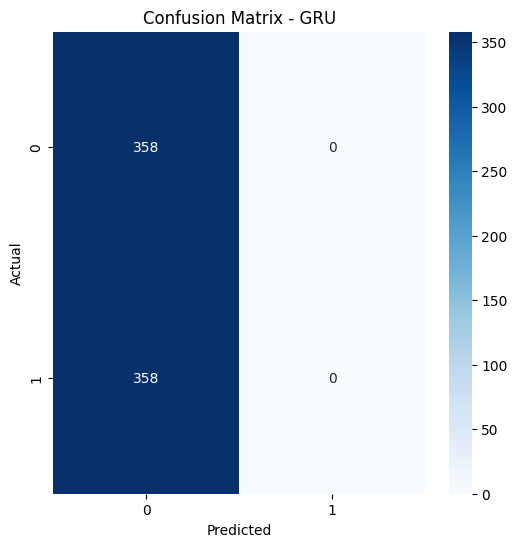

In [60]:
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(32, return_sequences=True),
    GRU(32),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

epochs = 5
history_gru = model_gru.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

# Plote os resultados
plt.figure(figsize=(8, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses - GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Avalie o modelo com dados de teste
loss_gru, accuracy_gru = model_gru.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (GRU): {loss_gru:.4f}")
print(f"Acurácia nos dados de teste (GRU): {accuracy_gru:.4f}")

# Faça as previsões e imprima o relatório de classificação
y_pred_gru = (model_gru.predict(padded_sequences_test) > 0.5).astype("int32")
report_gru = classification_report(y_test, y_pred_gru, target_names=encoder.classes_, output_dict=True)
print("Classificação Report (GRU):")
for label, metrics in report_gru.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg (GRU): {report_gru['macro avg']}")
print(f"Weighted Avg (GRU): {report_gru['weighted avg']}")
cm_gru = confusion_matrix(y_test, y_pred_gru)

# Plote a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GRU')
plt.show()



# Faça o mesmo processamento utilizando LSTM

Pelo menos duas camadas de LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 lstm (LSTM)                 (None, 280, 32)           6272      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1614625 (6.16 MB)
Trainable params: 1614625 (6.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
72/72 - 11s - loss: 0.6937 - accuracy: 0.4904 - val_loss: 0.6932 - val_accuracy: 0.4965 - 11s/epoch - 157ms/step
Epoch 2/5
72/72 - 4s - lo

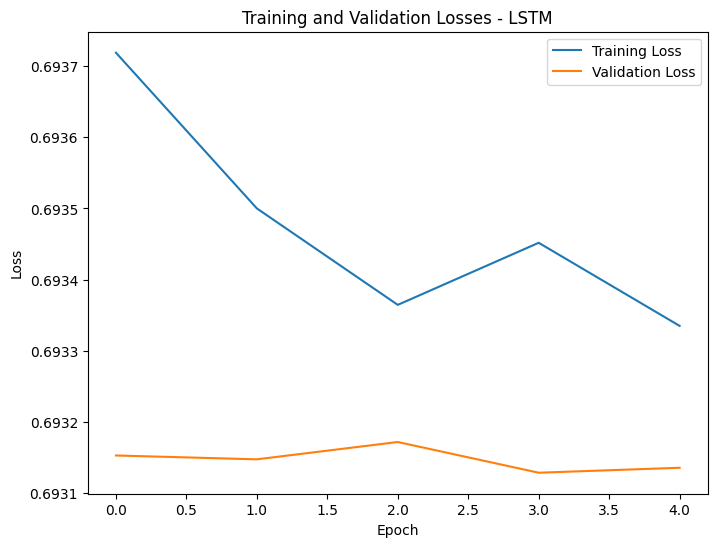

23/23 - 0s - loss: 0.6931 - accuracy: 0.5000 - 198ms/epoch - 9ms/step
Perda nos dados de teste (LSTM): 0.6931
Acurácia nos dados de teste (LSTM): 0.5000
23/23 [==============================] - 1s 9ms/step
Classificação Report (LSTM):
Class: 0
	Precision: 0.5
	Recall: 1.0
	F1-score: 0.6666666666666666
Class: 1
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Class: macro avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Class: weighted avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Macro Avg (LSTM): {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}
Weighted Avg (LSTM): {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


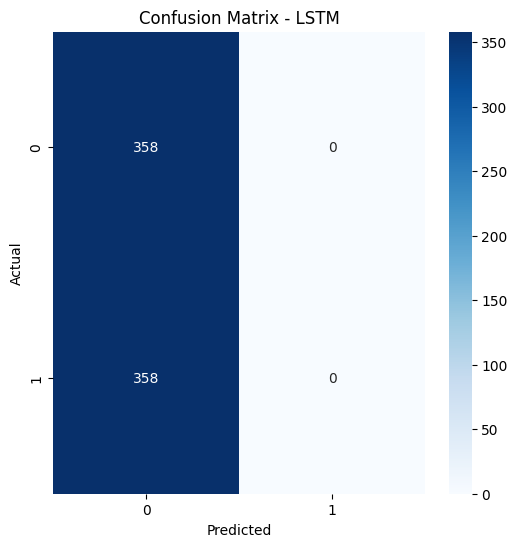

In [61]:
# ToDo
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

epochs = 5
history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

# Plote os resultados
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses - LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Avalie o modelo com dados de teste
loss_lstm, accuracy_lstm = model_lstm.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (LSTM): {loss_lstm:.4f}")
print(f"Acurácia nos dados de teste (LSTM): {accuracy_lstm:.4f}")

# Faça as previsões e imprima o relatório de classificação
y_pred_lstm = (model_lstm.predict(padded_sequences_test) > 0.5).astype("int32")
report_lstm = classification_report(y_test, y_pred_lstm, target_names=encoder.classes_, output_dict=True)
print("Classificação Report (LSTM):")
for label, metrics in report_lstm.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg (LSTM): {report_lstm['macro avg']}")
print(f"Weighted Avg (LSTM): {report_lstm['weighted avg']}")
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plote a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()


# Faça o mesmo processamento utilizando GRU Bi-direcionais

Pelo menos duas camadas de GRU bi-direcionais

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional (Bidirection  (None, 280, 64)           9600      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                18816     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1628481 (6.21 MB)
Trainable params: 1628481 (6.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
72/72 

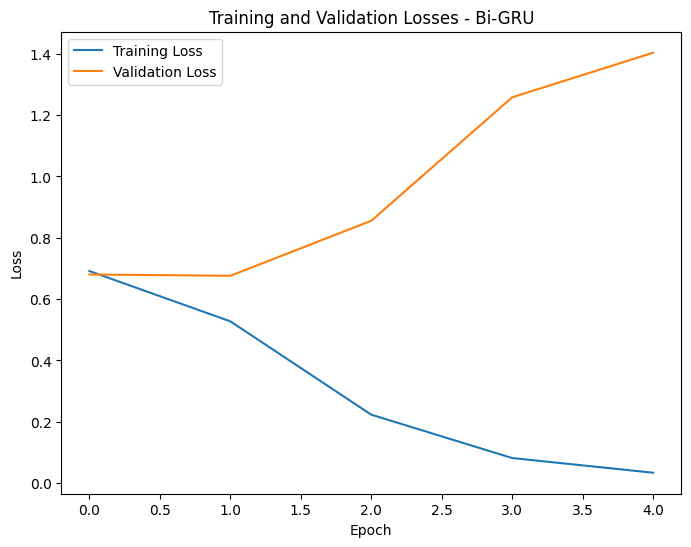

23/23 - 0s - loss: 1.3591 - accuracy: 0.6299 - 345ms/epoch - 15ms/step
Perda nos dados de teste (Bi-GRU): 1.3591
Acurácia nos dados de teste (Bi-GRU): 0.6299
23/23 [==============================] - 1s 15ms/step
Classificação Report (Bi-GRU):
Class: 0
	Precision: 0.6666666666666666
	Recall: 0.5195530726256983
	F1-score: 0.5839874411302982
Class: 1
	Precision: 0.6064073226544623
	Recall: 0.7402234636871509
	F1-score: 0.6666666666666667
Class: macro avg
	Precision: 0.6365369946605645
	Recall: 0.6298882681564246
	F1-score: 0.6253270538984825
Class: weighted avg
	Precision: 0.6365369946605645
	Recall: 0.6298882681564246
	F1-score: 0.6253270538984824
Macro Avg (Bi-GRU): {'precision': 0.6365369946605645, 'recall': 0.6298882681564246, 'f1-score': 0.6253270538984825, 'support': 716}
Weighted Avg (Bi-GRU): {'precision': 0.6365369946605645, 'recall': 0.6298882681564246, 'f1-score': 0.6253270538984824, 'support': 716}


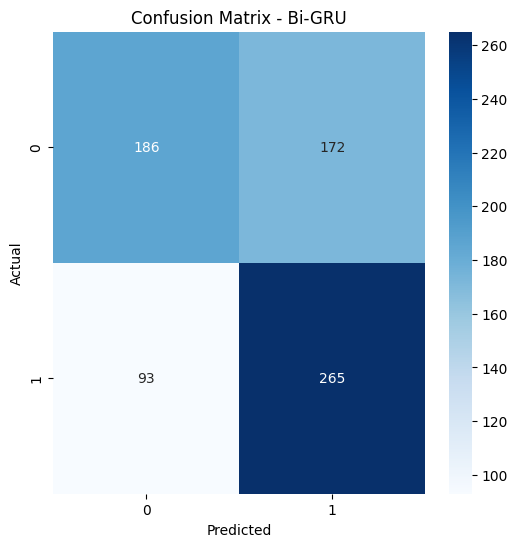

In [62]:
# ToDo
from tensorflow.keras.layers import Bidirectional, GRU

model_bi_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(32, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(1, activation='sigmoid')
])

model_bi_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi_gru.summary()

epochs = 5
history_bi_gru = model_bi_gru.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

# Plote os resultados
plt.figure(figsize=(8, 6))
plt.plot(history_bi_gru.history['loss'], label='Training Loss')
plt.plot(history_bi_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses - Bi-GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Avalie o modelo com dados de teste
loss_bi_gru, accuracy_bi_gru = model_bi_gru.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (Bi-GRU): {loss_bi_gru:.4f}")
print(f"Acurácia nos dados de teste (Bi-GRU): {accuracy_bi_gru:.4f}")

# Faça as previsões e imprima o relatório de classificação
y_pred_bi_gru = (model_bi_gru.predict(padded_sequences_test) > 0.5).astype("int32")
report_bi_gru = classification_report(y_test, y_pred_bi_gru, target_names=encoder.classes_, output_dict=True)
print("Classificação Report (Bi-GRU):")
for label, metrics in report_bi_gru.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg (Bi-GRU): {report_bi_gru['macro avg']}")
print(f"Weighted Avg (Bi-GRU): {report_bi_gru['weighted avg']}")
cm_bi_gru = confusion_matrix(y_test, y_pred_bi_gru)

# Plote a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm_bi_gru, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Bi-GRU')
plt.show()


# Faça o mesmo processamento utilizando LSTM Bi-direcionais

Pelo menos duas camadas de LSTM Bi-direcionais

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 280, 64)           12544     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1637441 (6.25 MB)
Trainable params: 1637441 (6.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
72/72 

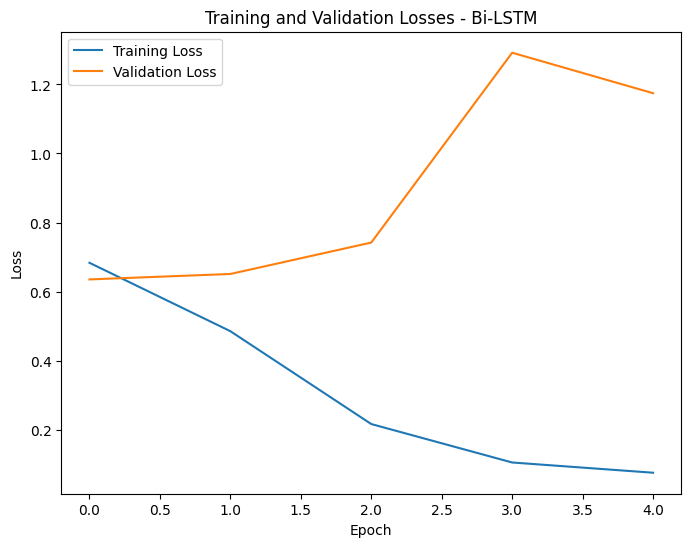

23/23 - 1s - loss: 1.0786 - accuracy: 0.6466 - 655ms/epoch - 28ms/step
Perda nos dados de teste (Bi-LSTM): 1.0786
Acurácia nos dados de teste (Bi-LSTM): 0.6466
23/23 [==============================] - 2s 22ms/step
Classificação Report (Bi-LSTM):
Class: 0
	Precision: 0.6454293628808865
	Recall: 0.6508379888268156
	F1-score: 0.6481223922114048
Class: 1
	Precision: 0.647887323943662
	Recall: 0.6424581005586593
	F1-score: 0.6451612903225807
Class: macro avg
	Precision: 0.6466583434122742
	Recall: 0.6466480446927374
	F1-score: 0.6466418412669928
Class: weighted avg
	Precision: 0.6466583434122742
	Recall: 0.6466480446927374
	F1-score: 0.6466418412669928
Macro Avg (Bi-LSTM): {'precision': 0.6466583434122742, 'recall': 0.6466480446927374, 'f1-score': 0.6466418412669928, 'support': 716}
Weighted Avg (Bi-LSTM): {'precision': 0.6466583434122742, 'recall': 0.6466480446927374, 'f1-score': 0.6466418412669928, 'support': 716}


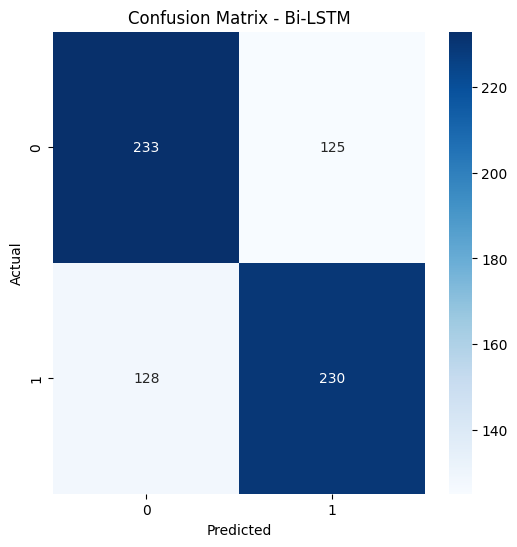

In [63]:
from tensorflow.keras.layers import Bidirectional, LSTM

model_bi_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model_bi_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi_lstm.summary()

epochs = 5
history_bi_lstm = model_bi_lstm.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

# Plote os resultados
plt.figure(figsize=(8, 6))
plt.plot(history_bi_lstm.history['loss'], label='Training Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses - Bi-LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Avalie o modelo com dados de teste
loss_bi_lstm, accuracy_bi_lstm = model_bi_lstm.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (Bi-LSTM): {loss_bi_lstm:.4f}")
print(f"Acurácia nos dados de teste (Bi-LSTM): {accuracy_bi_lstm:.4f}")

# Faça as previsões e imprima o relatório de classificação
y_pred_bi_lstm = (model_bi_lstm.predict(padded_sequences_test) > 0.5).astype("int32")
report_bi_lstm = classification_report(y_test, y_pred_bi_lstm, target_names=encoder.classes_, output_dict=True)
print("Classificação Report (Bi-LSTM):")
for label, metrics in report_bi_lstm.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg (Bi-LSTM): {report_bi_lstm['macro avg']}")
print(f"Weighted Avg (Bi-LSTM): {report_bi_lstm['weighted avg']}")
cm_bi_lstm = confusion_matrix(y_test, y_pred_bi_lstm)

# Plote a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm_bi_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Bi-LSTM')
plt.show()


# Faça o mesmo processamento utilizando redes recorrentes bi-direcionais e profundas

Pelo menos quatro camadas de GRU/LSTM bi-direcionais (ou não)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 280, 128)          31488     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 280, 128)          74496     
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                      

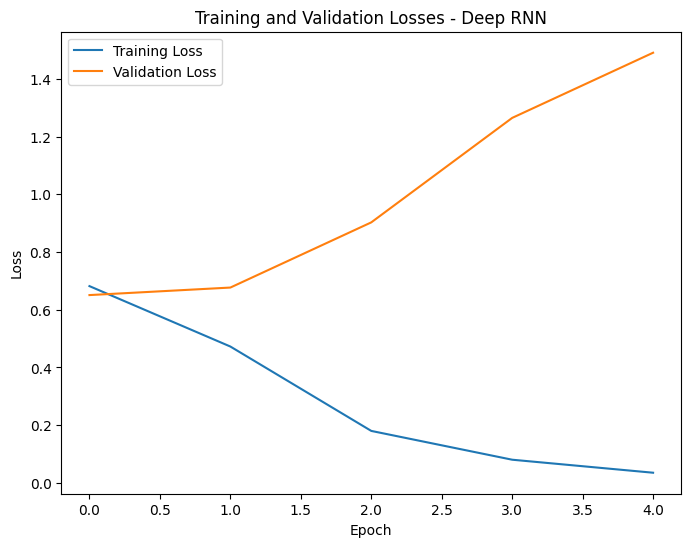

23/23 - 0s - loss: 1.4792 - accuracy: 0.6397 - 491ms/epoch - 21ms/step
Perda nos dados de teste (Deep RNN): 1.4792
Acurácia nos dados de teste (Deep RNN): 0.6397
23/23 [==============================] - 3s 27ms/step
Classificação Report (Deep RNN):
Class: 0
	Precision: 0.6207729468599034
	Recall: 0.7178770949720671
	F1-score: 0.6658031088082902
Class: 1
	Precision: 0.6655629139072847
	Recall: 0.5614525139664804
	F1-score: 0.6090909090909091
Class: macro avg
	Precision: 0.643167930383594
	Recall: 0.6396648044692738
	F1-score: 0.6374470089495996
Class: weighted avg
	Precision: 0.643167930383594
	Recall: 0.6396648044692738
	F1-score: 0.6374470089495997
Macro Avg (Deep RNN): {'precision': 0.643167930383594, 'recall': 0.6396648044692738, 'f1-score': 0.6374470089495996, 'support': 716}
Weighted Avg (Deep RNN): {'precision': 0.643167930383594, 'recall': 0.6396648044692738, 'f1-score': 0.6374470089495997, 'support': 716}


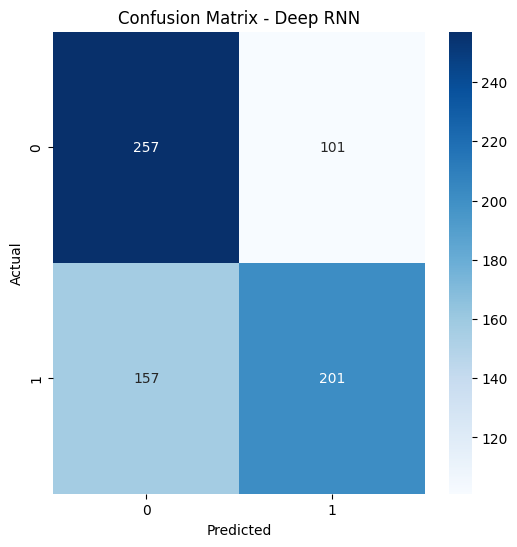

In [64]:
# ToDo
from tensorflow.keras.layers import Bidirectional, GRU, LSTM

model_deep_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(1, activation='sigmoid')
])

model_deep_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_deep_rnn.summary()

epochs = 5
history_deep_rnn = model_deep_rnn.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

# Plote os resultados
plt.figure(figsize=(8, 6))
plt.plot(history_deep_rnn.history['loss'], label='Training Loss')
plt.plot(history_deep_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses - Deep RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Avalie o modelo com dados de teste
loss_deep_rnn, accuracy_deep_rnn = model_deep_rnn.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (Deep RNN): {loss_deep_rnn:.4f}")
print(f"Acurácia nos dados de teste (Deep RNN): {accuracy_deep_rnn:.4f}")

# Faça as previsões e imprima o relatório de classificação
y_pred_deep_rnn = (model_deep_rnn.predict(padded_sequences_test) > 0.5).astype("int32")
report_deep_rnn = classification_report(y_test, y_pred_deep_rnn, target_names=encoder.classes_, output_dict=True)
print("Classificação Report (Deep RNN):")
for label, metrics in report_deep_rnn.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg (Deep RNN): {report_deep_rnn['macro avg']}")
print(f"Weighted Avg (Deep RNN): {report_deep_rnn['weighted avg']}")
cm_deep_rnn = confusion_matrix(y_test, y_pred_deep_rnn)

# Plote a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm_deep_rnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Deep RNN')
plt.show()


# *ToDo*: O que você pode analisar dos modelos treinados?

```
  Que o GRU e o LSTM desempenharam igualmente, podemos perceber que suas versões
  simples não foram capazes de capturar padrões mais complexos, diferentemente das
  versões bi-direcionais que conseguiram um desempenho ótimo.
```